In [6]:
from scipy.io import loadmat
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from smooth import smoothen


%matplotlib inline

In [4]:
filelist = ["calcium_data/140708B_140811a_result", 
            "calcium_data/140909C_141112a_result", 
            "calcium_data/141006C_141121a_result",
            "calcium_data/150109A_150302a_result", 
            "calcium_data/151122A_160202a_result", 
            "calcium_data/151122B_160207a_result", 
            "calcium_data/160209A_160430a_result", 
            "calcium_data/160209B_160428a_result"]

experiemntal parameters:

v(0): hit/miss, +1 for hit, -1 for miss

v(1): stimulus intensity

v(2): rest of variance

In [50]:
def preprocessing(filename, time='full', windows=None, z_score=True, smooth=True):
    '''
    Preprocesses the data according to specified parameters
    
    filename: string, specifies file to use. If None, concatenate all files
    time: string
        'full' - use full time series of the dendritic Ca2+ signal
        'windowed' - use only one point per dendrite, averaged over specified window
    windows: ndarray, 7x2 or n_filesx7x2. 
        Required in windowed mode. Array holds start- and stop times for each stimulus.
    z_score: bool, whether to z-score the data. 
    '''
    
    assert(not(time=='windowed') or not(windows == None))
    
    #get the data we need into the format we need
    if type(filename) == list:
        #create concatenated data, prompt if file already exitsts
        #in this case, other experiments are interpreted as different units, but same trials as
        #other units. Not all experiments have same units, and not same stimuli, so...later.
        try:
            f = h5py.File('allexp.hdf5', 'w-')
        except OSError:
            print('file already exists, type "continue" to overwrite \n')
            if input() == 'continue':
                f = h5py.File('allexp.hdf5', 'w')
                
        #filename denotes a list of files in this case
        for file in filename:
            #finish later, or probably not
            pass
    else:
        #just load data from specified file
        f = h5py.File(filename+'.hdf5', 'r')
        g = h5py.File(filename[:-6]+"roi.hdf5", "r")
        motion_mask = (g['inFrameDend'][:].astype(bool)).reshape(g['inFrameDend'].shape[0])
        
        data = f['data'][:, motion_mask, :]
        meta = f['meta']
    
    if time == 'full':
        #keep all times
        data_pass = data[:]
        if smooth:
            #if we smoothen the data
            data_pass = smoothen(filename)[:,motion_mask,:]
        meta_pass = meta[:]
        
    if time == 'windowed':
        #get window-averaged
        meta_pass = meta[:]
        data_pass = np.zeros((data.shape[0], data.shape[1]))
        
        stims = np.unique(meta[:,1])
        for i, amp in enumerate(stims):
            amp_mask = meta[:,1] == amp
            data_pass[amp_mask] = np.mean(data[amp_mask,:,windows[i,0], windows[i,1]], axis=2)
            
    if z_score:
        #z_score signal
        mns = np.mean(data_pass, axis=0)
        try:
        #specify exception
            mns = np.mean(mns, axis=1)
        except:
            print('Exception triggered')
        stds = np.std(data_pass, axis=0)
        try:
            stds = np.std(stds, axis=1)
        except:
            print('Exception triggered')
            
        mns = np.transpose(np.tile(mns, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        stds = np.transpose(np.tile(stds, (data.shape[0], data.shape[2], 1)), axes=[0,2,1])
        
        data_pass = data_pass - mns
        data_pass = data_pass/stds
            
    #possibly add functionality for subtracting mean, but not dividing by std.
    return meta_pass, data_pass

In [51]:
m, d = preprocessing(filelist[0], time='full', windows=None, z_score=True, smooth=True)

8.3036033128852296

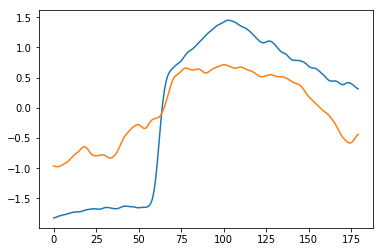

In [85]:
plt.plot(np.mean(d[:,106,:], axis=0))
plt.plot(np.mean(d[:,100,:], axis=0))
np.std(d[:,107,:])

In [56]:
def get_betas(data):
    n_trials = data.shape[0]
    n_units = data.shape[1]
    n_times = data.shape[2]
    
    F_i = np.ones((3, n_trials))
    
    #tensor math more efficient?
    beta = np.zeros((n_units, n_times, n_trials))
    F_fac = np.dot(np.linalg.inv(np.dot(F_i, F_i.T)), F_i)
    
    for i in range(n_units):
        for t in range(n_times):
            r_it = data[:,i,t]
            beta[i, t, :] = np.dot(F_fac, r_it)
            
    return beta

In [ ]:
def get_population_response(meta, data):
    n_units = data.shape[1]
    n_trials = data.shape[0]
    
    outcomes = np.zeros(n_trials)
    for i in range(n_trials):
        if meta[i,1] == 0 and meta[i,2] == 0:
            outcomes[i] = 1
        else:
            outcomes[i] = 0
    
    conditions = {'hitmiss':meta[:,2], 'stim':meta[:,1], 'outcome':outcomes}
    
    for condition in conditions.keys():
        for i in range(n_units):
            vals = np.unique(conditions[condition])
            for val in vals:
                mask = conditions[condition] == val
                x_ct = np.mean(data[mask, i], axis=0)
